## Imports

In [82]:
!git clone https://github.com/rmnigm/qber-forecasting.git

fatal: destination path 'qber-forecasting' already exists and is not an empty directory.


In [83]:
import collections
import math
import os
import pathlib
import random


import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import scipy.stats as sps
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from tempfile import TemporaryDirectory

from tqdm.notebook import tqdm

In [84]:
def seed_everything(seed: int) -> None:
    """Fix all the random seeds we can for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Models

In [ ]:
!pip install rtdl_revisiting_models

In [ ]:
from rtdl_revisiting_models import MLP, ResNet, FTTransformer

## Training

In [ ]:
!pip install torchmetrics

In [ ]:
from tqdm.auto import tqdm
from torchmetrics import R2Score

In [ ]:
METRIC = R2Score().to(device)

def train(model: nn.Module, train_loader, epoch):
    model.train()
    total_loss = 0.
    log_interval = 100
    losses = []
    predictions, targets = [], []

    for i, batch in enumerate(tqdm(train_loader)):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        # logits = model(x)
        # probs = logits.softmax(dim=1)
        # predictions = (x * probs).sum(dim=1)
        if isinstance(model, FTTransformer):
            preds = model(x, None).flatten()
        else:
            preds = model(x).flatten()

        loss = criterion(preds, y) * 10e6
        loss.backward()
        optimizer.step()

        predictions.append(preds)
        targets.append(y)

    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    loss = criterion(predictions, targets)
    metric = METRIC(targets, predictions)
    return loss.item(), metric.cpu().item()


def evaluate(model: nn.Module, test_loader) -> float:
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for i, batch in enumerate(tqdm(test_loader)):
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            # logits = model(x)
            # probs = logits.softmax(dim=1)
            # predictions = (x * probs).sum(dim=1)
            if isinstance(model, FTTransformer):
                preds = model(x, None).flatten()
            else:
                preds = model(x).flatten()
            predictions.append(preds)
            targets.append(y)

        predictions = torch.cat(predictions)
        targets = torch.cat(targets)
        loss = criterion(predictions, targets)
        metric = METRIC(targets, predictions)
    return loss.item(), metric.cpu().item()

In [ ]:
from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
columns_dict = {
    1: 'blockId',
    2: 'frameIdx',
    3: 'frameError',
    4: 'byDecoyEst',
    5: 'byDecoyZ',
    6: 'byVacuumZ',
    7: 'nmuSend',
    8: 'nnuSend',
    9: 'nlSend',
    10: 'nmuReg',
    11: 'nnuReg',
    12: 'nlReg',
    13: 'roundDistribution',
    14: 'maintenanceFlag',
    16: 'ema_est',
    17: 'ema_f_ec',
    19: 'vema_est',
    20: 'vema_f_ec',
    22: 'ml_est',
    23: 'ml_f_ec',
    25: 'phys_est',
    26: 'phys_f_ec',
}

In [ ]:
data = pl.read_csv('/content/drive/MyDrive/Datasets/qber/frames_errors_12-03.csv', has_header=False)

In [ ]:
data = data[:, [k-1 for k in columns_dict.keys()]]
data.columns = list(columns_dict.values())
data = data.select(
    pl.col('vema_f_ec').cast(float).alias('vema_f_ec'),
    pl.col('phys_f_ec').cast(float).alias('phys_f_ec'),
    pl.col('ema_f_ec').cast(float).alias('ema_f_ec'),
    pl.col('ml_f_ec').cast(float).alias('ml_f_ec'),
    pl.col('vema_est').cast(float).alias('vema_est'),
    pl.col('phys_est').cast(float).alias('phys_est'),
    pl.col('ema_est').cast(float).alias('ema_est'),
    pl.col('ml_est').cast(float).alias('ml_est'),
    pl.col('frameError').alias('qber_mu'),
    pl.col('byDecoyEst').alias('qber_prob_model'),
    pl.col('byDecoyZ').alias('qber_nu_1'),
    pl.col('byVacuumZ').alias('qber_nu_2'),
    (pl.col('nmuReg') /  pl.col('nmuSend')).alias('q_mu'),
    (pl.col('nnuReg') /  pl.col('nnuSend')).alias('q_nu_1'),
    (pl.col('nlReg') /  pl.col('nlSend')).alias('q_nu_2'),
    pl.col('maintenanceFlag').alias('maintenance'),
    (pl.col('frameError') - pl.col('ml_est')).abs().alias('ml_err'),
    (pl.col('frameError') - pl.col('ema_est')).abs().alias('ema_err'),
    (pl.col('frameError') - pl.col('vema_est')).abs().alias('vema_err'),
    (pl.col('frameError') - pl.col('phys_est')).abs().alias('phys_err'),
)
ts = data['qber_mu']
ema_ts = data['ema_est']

In [ ]:
class Data(Dataset):
    def __init__(self,
                 dataframe: pl.DataFrame,
                 window_size: int,
                 dtype: torch.dtype = torch.float32,
                 columns: list[str] | None = None,
                 offset: int | float = None,
                 limit: int | float = None,
                 flatten: bool = True,
                 ):
        assert window_size is not None
        self.window_size = window_size
        self.build_dataset(dataframe, offset, limit, columns)
        self.dtype = dtype
        self.flatten = flatten

    def build_dataset(self, dataframe, offset, limit, columns) -> None:
        length = len(dataframe)
        offset, limit = self.calculate_offset_limit(offset, limit, length)
        columns = columns or dataframe.columns
        dataframe = (
            dataframe
            .select(columns)
            .slice(offset, limit)
        )
        self.data_array = dataframe.to_numpy()
        self.dataset = np.lib.stride_tricks.sliding_window_view(
            self.data_array,
            self.window_size + 1,
            axis=0
            )
        self.shape = self.dataset.shape[1:]

    @staticmethod
    def calculate_offset_limit(offset, limit, length) -> tuple[int, int]:
        if offset is None:
          offset = 0
        else:
          offset = offset if offset >= 1 else int(offset * length)
        if limit is None:
          limit = length
        else:
          limit = limit if limit >= 1 else int(limit * length)
        return offset, limit


    def __len__(self) -> int:
        return len(self.dataset)

    def __repr__(self) -> str:
        return f'PolarsDataset(len={self.__len__()})'

    def __getitem__(self, idx) -> tuple[Tensor, Tensor]:
        x = self.dataset[idx][0, :-1]
        y = self.dataset[idx][0, -1]
        if self.flatten:
            x = x.flatten()
        x = torch.tensor(x, dtype=self.dtype)
        y = torch.tensor(y, dtype=self.dtype)
        return x, y

In [ ]:
columns = ["qber_mu", "qber_nu_1"]

train_dataset = Data(data, window_size=20, columns=columns, limit=0.75)
test_dataset = Data(data, window_size=20, columns=columns, offset=0.75)

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size
    )
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=batch_size
    )

In [ ]:
d_in = 20
d_out = 1

# model = MLP(
#     d_in=d_in,
#     d_out=d_out,
#     n_blocks=2,
#     d_block=384,
#     dropout=0.1,
# )
# model = FTTransformer(
#     n_cont_features=d_in,
#     cat_cardinalities=0,
#     d_out=d_out,
#     **FTTransformer.get_default_kwargs(),
# )

model = ResNet(
    d_in=d_in,
    d_out=d_out,
    n_blocks=2,
    d_block=192,
    d_hidden=None,
    d_hidden_multiplier=2.0,
    dropout1=0.15,
    dropout2=0.0,
)

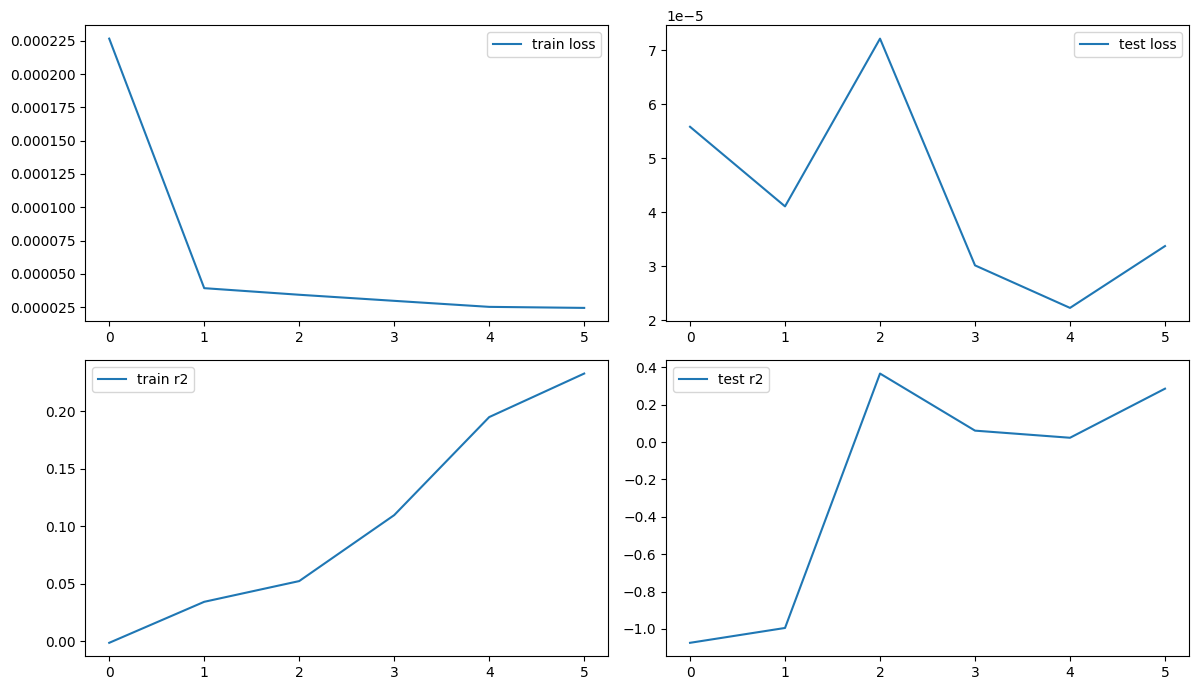

In [ ]:
%%time

seed_everything(123456)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# optimizer = model.make_default_optimizer()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

best_val_r2 = -float('inf')
epochs = 10

with TemporaryDirectory() as tempdir:
    model.to(device)
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")
    train_losses, val_losses = [], []
    train_r2, val_r2 = [], []

    for epoch in range(1, epochs + 1):
        epoch_train_loss, epoch_train_r2 = train(model, train_loader, epoch)
        epoch_val_loss, epoch_val_r2 = evaluate(model, test_loader)

        train_losses.append(epoch_train_loss)
        train_r2.append(epoch_train_r2)
        val_losses.append(epoch_val_loss)
        val_r2.append(epoch_val_r2)

        if epoch_val_r2 < best_val_r2:
            best_val_r2 = epoch_val_r2
            torch.save(model.state_dict(), best_model_params_path)

        scheduler.step()
        clear_output(wait=True)
        fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 7))
        sns.lineplot(train_losses, label="train loss", ax=axes[0][0])
        sns.lineplot(val_losses, label="test loss", ax=axes[0][1])
        sns.lineplot(train_r2, label="train r2", ax=axes[1][0])
        sns.lineplot(val_r2, label="test r2", ax=axes[1][1])
        plt.tight_layout()
        plt.legend()
        plt.show()
        print(f"epoch {epoch}")
        print(f"train loss = {train_losses[-1]:.6f}")
        print(f"test loss = {val_losses[-1]:.6f}")
        print(f"train R^2 = {train_r2[-1]:.6f}")
        print(f"test R^2 = {val_r2[-1]:.6f}")

    model.load_state_dict(torch.load(best_model_params_path)) # load best model states

In [86]:
def eval_metrics(model, train_loader):
    model.eval()
    model.to(device)
    predictions, targets = [], []
    with torch.no_grad():
        for batch, target in train_loader:
            preds = model(batch.to(device)).flatten()
            predictions.append(preds)
            targets.append(target.to(device))
    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    return METRIC(targets, predictions).cpu().item()

In [87]:
print("train:", eval_metrics(model, train_loader))
print("test:", eval_metrics(model, test_loader))

train: 0.35172051191329956
test: 0.42425405979156494


### sklearn big oof moment

In [90]:
def to_flat(loader):
    x, y = [], []
    for b, t in loader:
        x.append(np.array(b))
        y.append(np.array(t))
    x = np.concatenate(x)
    y = np.concatenate(y)
    return x, y

In [146]:
train_x, train_y = to_flat(train_loader)
test_x, test_y = to_flat(test_loader)

In [106]:
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

In [154]:
pipe1 = make_pipeline(
    RobustScaler(),
    MLPRegressor()
)

pipe2 = make_pipeline(
    Nystroem(),
    Ridge()
)

In [155]:
%%time
pipe1.fit(train_x, train_y)
preds = pipe1.predict(test_x)

print(r2_score(test_y, preds), mean_squared_error(test_y, preds))
pipe1

0.47328167525262066 2.7217726e-05
CPU times: user 26.4 s, sys: 20.3 s, total: 46.7 s
Wall time: 30.1 s


Pipeline(steps=[('robustscaler', RobustScaler()),
                ('mlpregressor', MLPRegressor())])

In [156]:
%%time
pipe2.fit(train_x, train_y)
preds = pipe2.predict(test_x)

print(r2_score(test_y, preds), mean_squared_error(test_y, preds))
pipe2

0.440846487972147 2.8893788e-05
CPU times: user 1.14 s, sys: 690 ms, total: 1.83 s
Wall time: 969 ms


Pipeline(steps=[('nystroem', Nystroem()), ('ridge', Ridge())])